In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasetsss/sentiment_statisticscc1e57a.csv
/kaggle/input/datasetsss/customers2afd6ea.csv
/kaggle/input/datasetsss/testbc7185d.csv
/kaggle/input/datasetsss/callsf0d4f5a.csv
/kaggle/input/datasetsss/reason18315ff.csv


In [2]:
calls = pd.read_csv("/kaggle/input/datasetsss/callsf0d4f5a.csv")
customers = pd.read_csv("/kaggle/input/datasetsss/customers2afd6ea.csv")
reason = pd.read_csv("/kaggle/input/datasetsss/reason18315ff.csv")
sentiments = pd.read_csv("/kaggle/input/datasetsss/sentiment_statisticscc1e57a.csv")
test = pd.read_csv("/kaggle/input/datasetsss/testbc7185d.csv")

In [3]:
calls['call_transcript'][0]

"\n\nAgent: Thank you for calling United Airlines customer service, my name is Sarah how may I help you?\n\nCustomer: Hi, yeah I'm calling because my flight from Chicago to New York was delayed by over 3 hours! This is ridiculous, I'm missing important meetings because of this. \n\nAgent: I'm so sorry to hear about the delay, that's definitely frustrating. Umm, let me pull up your reservation and take a look at what happened. *typing sounds* Okay, it looks like there was severe weather in Chicago that caused multiple flight cancellations and delays across the board for all the airlines. Ahh shoot, yeah your original flight was scheduled to depart at 2pm but didn't actually take off until after 5pm.\n\nCustomer: Ugh this is such poor planning on United's part, you should have rerouted passengers or put us on other flights that weren't delayed. Now I've wasted a whole day. \n\nAgent: I understand your frustration sir, delays are never fun. Let me see what options I have available to help

In [4]:
calls_new = calls.copy()

# # # # # # # # #  Cleaning the transcript

In [5]:
import re

def clean_transcript(transcript):
    # Removing agent dialogs
    cleaned_transcript = re.sub(r'\n*Agent:.*?(?=\n|$)', '', transcript)
    
    # Removing all instances of "Customer:"
    cleaned_transcript = re.sub(r'(?i)\bCustomer:\s*', '', cleaned_transcript)
    
    # Removing any leading/trailing whitespace and extra newlines
    cleaned_transcript = re.sub(r'\s+', ' ', cleaned_transcript).strip()
    cleaned_transcript = re.sub(r'\n+', '\n', cleaned_transcript).strip()
    
    return cleaned_transcript


In [6]:
calls_new['cleaned_transcript'] = calls_new['call_transcript'].apply(clean_transcript)
calls_new['cleaned_transcript'][0]

"Hi, yeah I'm calling because my flight from Chicago to New York was delayed by over 3 hours! This is ridiculous, I'm missing important meetings because of this. Ugh this is such poor planning on United's part, you should have rerouted passengers or put us on other flights that weren't delayed. Now I've wasted a whole day. I guess that's better than nothing. But you really need to get your act together, this is unacceptable customer service from United. Your delays are costing people time and money. Alright fine. This better not happen again next time I fly United. Yeah, you too. *hangs up*"

In [7]:
calls_new.drop('call_transcript', axis = 1, inplace = True)

In [8]:
reason['primary_call_reason'].unique()

array(['Voluntary  Cancel', 'Booking', 'IRROPS', 'Upgrade', 'Seating',
       'Mileage   Plus', 'Checkout', 'Voluntary   Change', 'Post Flight',
       'Check In', 'Other  Topics', 'Communications', 'Schedule Change',
       'Products & Services', 'IRROPS  ', 'Digital   Support',
       'Seating  ', 'Disability', 'Unaccompanied Minor', ' Baggage',
       'Traveler  Updates', 'Communications  ', 'ETC', 'Upgrade  ',
       'Unaccompanied Minor  ', 'Voluntary Change', 'Voluntary Change  ',
       'Checkout  ', 'Mileage Plus', 'Mileage Plus  ', 'Booking  ',
       'Baggage  ', 'Post-Flight', 'Post-Flight  ', 'Schedule Change  ',
       'Baggage', 'Traveler Updates', 'Voluntary Cancel', 'Check-In',
       'Products and Services', 'Check-In  ', 'Other Topics',
       'Other Topics  ', 'ETC  ', 'Disability  ', 'Digital Support',
       'Digital Support  ', 'Voluntary Cancel  ',
       'Products and Services  ', 'Traveler Updates  ',
       'Traveler   Updates', 'Digital  Support', 'Mileage  P

In [9]:
merged = pd.merge(calls_new, reason, on='call_id')
without_test = merged[~merged['call_id'].isin(test['call_id'])]

without_test.drop(columns=['customer_id', 'agent_id', 'call_start_datetime', 'call_end_datetime', 'agent_assigned_datetime'], inplace = True)

# # # # # # # # Preparing primary_call_reason column

In [10]:
without_test['primary_call_reason'] = (
    without_test['primary_call_reason']
    .str.replace(r'\s{2,}', ' ', regex=True)  # Replaced more than two spaces with one space
    .str.replace(r'-', ' ', regex=True)      # Replaced hyphen with one space
    .str.replace(r'&', 'and', regex=True)     # Replaced '&' with 'and'
    .str.strip()                               # Removed leading and trailing spaces
)

In [11]:
without_test['primary_call_reason'].unique()

array(['Voluntary Cancel', 'Booking', 'IRROPS', 'Upgrade', 'Seating',
       'Mileage Plus', 'Checkout', 'Voluntary Change', 'Post Flight',
       'Check In', 'Other Topics', 'Communications', 'Schedule Change',
       'Products and Services', 'Digital Support', 'Disability',
       'Unaccompanied Minor', 'Baggage', 'Traveler Updates', 'ETC'],
      dtype=object)

In [ ]:
test_data = calls_new[calls_new['call_id'].isin(test['call_id'])]
test_data.drop(columns=['customer_id', 'agent_id', 'call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime'], axis = 1, inplace = True)

# # # # # # # Generating Bigrams

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')


def generate_bag_of_bigrams(df):
    problem_bigrams = {}
    
    # Group by primary_call_reason and process each group
    for problem_type, group in df.groupby('primary_call_reason'):
        transcripts = group['cleaned_transcript'].values
        
        X = vectorizer.fit_transform(transcripts)
        
        bigram_counts = X.sum(axis=0)
        bigrams = vectorizer.get_feature_names_out()
        
        bigram_count_dict = dict(zip(bigrams, bigram_counts.A1))
        filtered_bigrams = {bigram: count for bigram, count in bigram_count_dict.items() if count > 50}
        
        # Storing the filtered bigram countings
        problem_bigrams[problem_type] = filtered_bigrams
    
    return problem_bigrams


problem_bigrams = generate_bag_of_bigrams(without_test)

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Defining some custom stopwords beacuse of the repeatation
custom_stopwords = set(STOPWORDS).union({
    'flight', 'yeah', 'appreciate', 'really', 'calling', 'thank', 'help', 'let', 'need', 'good', 'booked', 'know', 'umm', 'new', 'york', 'san', 'francisco', 'chicago', 'day', 'rest', 'date', 'time'
})

def generate_wordclouds(problem_bigrams):
    for problem_type, bigrams in problem_bigrams.items():
        wordcloud_input = ' '.join([bigram for bigram, count in bigrams.items() for _ in range(count)])
        
        wordcloud = WordCloud(width=800, height=400, 
                              background_color='white', 
                              stopwords=custom_stopwords).generate(wordcloud_input)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {problem_type}")
        plt.show()


generate_wordclouds(problem_bigrams)

In [15]:
urgency_keywords = ['immediately', 'urgent', 'asap', 'emergency', 'now', 'important', 'critical', 'hurry', 'fast']

def tokenize(text):
    text = text.lower()
    return re.findall(r'\b\w+\b', text)

def classify_urgency(transcript, urgency_keywords):
    words = tokenize(transcript)
    for keyword in urgency_keywords:
        if keyword in words:
            return 1  # Urgent
    return 0  # Not urgent


In [20]:
urgency_ana = without_test.copy()

In [22]:
urgency_ana['urgent'] = urgency_ana['cleaned_transcript'].apply(lambda x: classify_urgency(x, urgency_keywords))

In [26]:
urgency_ana

,call_id,cleaned_transcript,primary_call_reason,urgent
0,4667960400,"Hi, yeah I'm calling because my flight from Ch...",Voluntary Cancel,1
1,1122072124,"Hi Sam, yeah I'm calling because I need to cha...",Booking,1
2,6834291559,"Hi Steve, uh, I'm calling because I need to ma...",IRROPS,0
3,2266439882,"Hi, yeah I'm calling because I'm having some i...",Upgrade,1
4,1211603231,"Hi Sarah, thanks for taking my call. I'm calli...",Seating,0
...,...,...,...,...
66648,7569738090,"Hi, yeah I'm calling because I have a problem ...",Mileage Plus,0
66649,1563273072,"Hi Dave, yeah I'm calling in about a flight I ...",Post Flight,0
66650,8865997781,"Hi, yeah I'm calling because I'm really not ha...",Upgrade,1
66651,8019240181,"Hi Steven, umm I was hoping you could help me ...",Upgrade,0


In [27]:
non_urgent_calls = urgency_ana[urgency_ana['urgent'] == 0]
non_urgent_counts = non_urgent_calls.groupby('primary_call_reason').size()

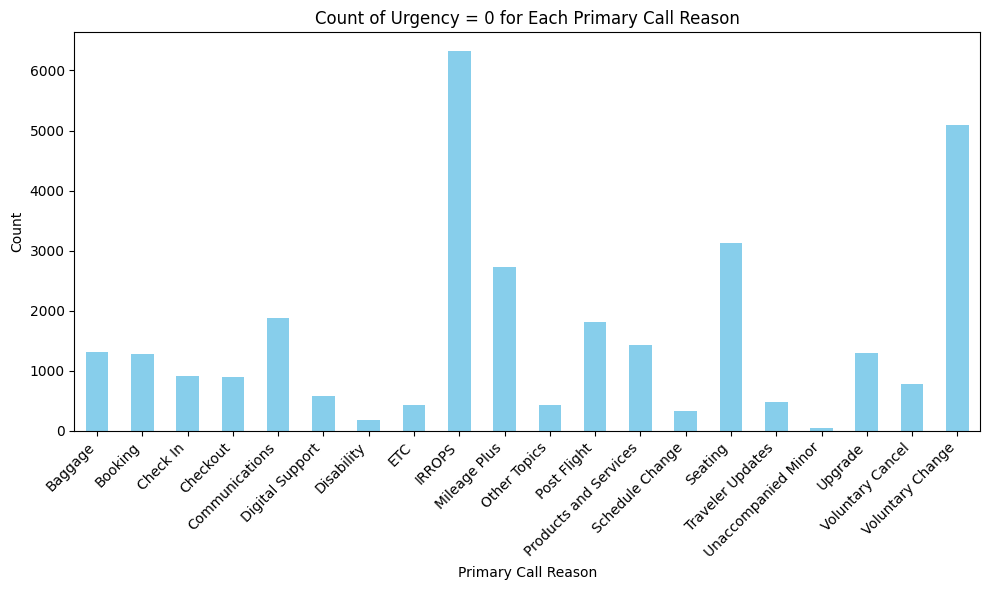

In [29]:
import matplotlib.pyplot as plt
non_urgent_counts.plot(kind='bar', color='skyblue', figsize=(10, 6), title='Count of Urgency = 0 for Each Primary Call Reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [52]:
# Defined IVR-resolvable issues with associated keywords
IVR_KEYWORDS = {
    "booking_change": ["change booking", "cancel booking", "modify booking", "reschedule flight"],
    "flight_status": ["status of my flight", "delayed flight", "arrival time", "flight on time"],
    "baggage_inquiry": ["lost baggage", "baggage status", "track my baggage", "baggage missing", "baggage policy"],
    "refund_request": ["refund request", "refund status", "money back", "cancellation refund"]
}

# Function to assess whether a transcript could be resolved via IVR
def assess_ivr_suitability(transcript):
    transcript = transcript.lower()
    
    # Default to agent intervention unless a match is found
    ivr_resolvable = "No IVR-resolvable issues identified. Likely requires agent intervention."
    
    # Check each issue type and corresponding keywords
    for issue_type, keywords in IVR_KEYWORDS.items():
        for keyword in keywords:
            # If a keyword is found, mark it as IVR-resolvable
            if re.search(rf"\b{keyword}\b", transcript):
                ivr_resolvable = f"Potential IVR-resolvable issue: {issue_type.replace('_', ' ').capitalize()}."
                break
        if "IVR-resolvable" in ivr_resolvable:
            break
    
    return ivr_resolvable

# Function to assess all transcript instances in the feature
def assess_ivr_suitability_for_all_transcripts(df, transcript_col):
    # Apply the IVR suitability check to each transcript in the feature column
    df['ivr_suitability'] = df[transcript_col].apply(assess_ivr_suitability)
    return df

In [53]:
assess_ivr_suitability_for_all_transcripts(without_test, 'cleaned_transcript')

,call_id,cleaned_transcript,primary_call_reason,urgent,ivr_suitability
0,4667960400,"Hi, yeah I'm calling because my flight from Ch...",Voluntary Cancel,NaN,No IVR-resolvable issues identified. Likely re...
1,1122072124,"Hi Sam, yeah I'm calling because I need to cha...",Booking,NaN,No IVR-resolvable issues identified. Likely re...
2,6834291559,"Hi Steve, uh, I'm calling because I need to ma...",IRROPS,NaN,No IVR-resolvable issues identified. Likely re...
3,2266439882,"Hi, yeah I'm calling because I'm having some i...",Upgrade,NaN,No IVR-resolvable issues identified. Likely re...
4,1211603231,"Hi Sarah, thanks for taking my call. I'm calli...",Seating,NaN,No IVR-resolvable issues identified. Likely re...
...,...,...,...,...,...
66648,7569738090,"Hi, yeah I'm calling because I have a problem ...",Mileage Plus,NaN,No IVR-resolvable issues identified. Likely re...
66649,1563273072,"Hi Dave, yeah I'm calling in about a flight I ...",Post Flight,NaN,No IVR-resolvable issues identified. Likely re...
66650,8865997781,"Hi, yeah I'm calling because I'm really not ha...",Upgrade,NaN,No IVR-resolvable issues identified. Likely re...
66651,8019240181,"Hi Steven, umm I was hoping you could help me ...",Upgrade,1.0,No IVR-resolvable issues identified. Likely re...
